Starting training and information plane tracking (GMM-based MI with sklearn)...
Epoch 1/1000, Loss: 0.2117, Test Accuracy: 0.8750
Epoch 100/1000, Loss: 0.3593, Test Accuracy: 0.8720
Epoch 200/1000, Loss: 0.1304, Test Accuracy: 0.8750
Epoch 300/1000, Loss: 0.3732, Test Accuracy: 0.8720
Epoch 400/1000, Loss: 0.1825, Test Accuracy: 0.8750
Epoch 500/1000, Loss: 0.1815, Test Accuracy: 0.8750
Epoch 600/1000, Loss: 0.2958, Test Accuracy: 0.8740
Epoch 700/1000, Loss: 0.3084, Test Accuracy: 0.8730
Epoch 800/1000, Loss: 0.2288, Test Accuracy: 0.8720
Epoch 900/1000, Loss: 0.2592, Test Accuracy: 0.8730
Epoch 1000/1000, Loss: 0.3561, Test Accuracy: 0.8750
Training finished.


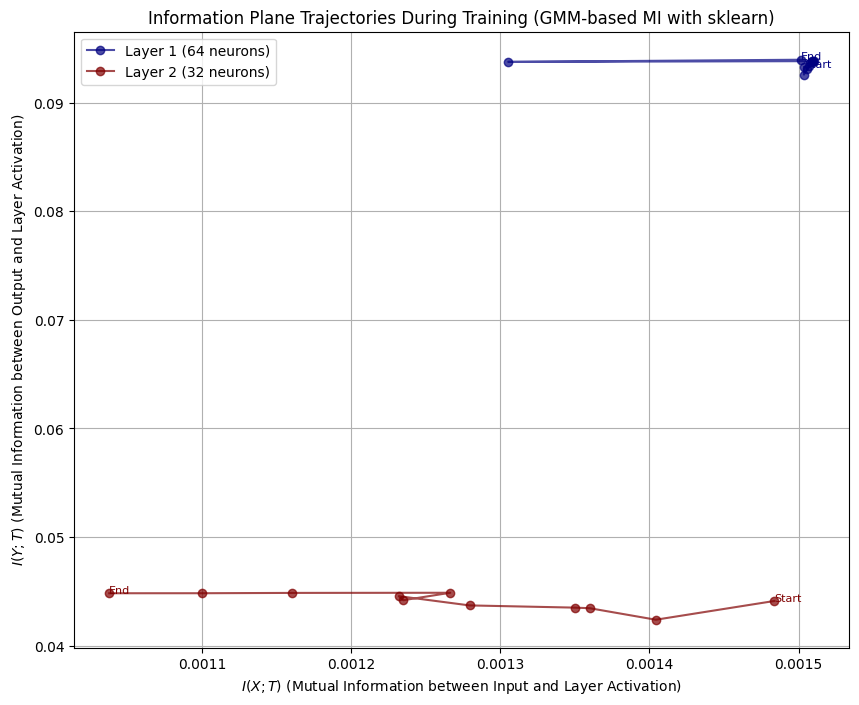

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture # <-- Using sklearn for GMMs
from scipy.special import logsumexp # For GMM entropy calculation (though score_samples is used)

# --- 1. Synthetic Data Generation ---
def generate_synthetic_data(num_samples, slope, intercept, noise_std, classification_threshold):
    """
    Generates synthetic data for a binary classification task.
    Input X: Uniform(0, 1)
    Continuous Y: slope * X + intercept + Gaussian_noise
    Binary Y: 1 if Continuous Y > classification_threshold, else 0
    """
    X = np.random.uniform(0, 1, num_samples)
    noise = np.random.normal(0, noise_std, num_samples)
    Y_continuous = slope * X + intercept + noise
    Y_binary = (Y_continuous > classification_threshold).astype(int)

    # Reshape for PyTorch compatibility (add feature dimension)
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    Y_tensor = torch.tensor(Y_binary, dtype=torch.float32).unsqueeze(1)
    return X_tensor, Y_tensor, X, Y_binary # Return numpy arrays for MI estimation

# --- 2. Neural Network Architecture ---
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(SimpleNN, self).__init__()
        layers = []
        # Store activations *after* ReLU for Information Plane
        self.linear_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()

        # Input layer to first hidden layer
        self.linear_layers.append(nn.Linear(input_dim, hidden_dims[0]))
        self.relu_layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            self.linear_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.relu_layers.append(nn.ReLU())

        # Output layer (no ReLU before sigmoid)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.sigmoid = nn.Sigmoid()

        self.activations = {} # To store activations for information plane

    def forward(self, x):
        # Store input x for I(X;T)
        self.activations['input'] = x.detach().cpu().numpy()

        current_activation = x
        for i, (linear_layer, relu_layer) in enumerate(zip(self.linear_layers, self.relu_layers)):
            current_activation = linear_layer(current_activation)
            current_activation = relu_layer(current_activation)
            # Store the activation after ReLU
            self.activations[f'hidden_{i}'] = current_activation.detach().cpu().numpy()

        output = self.output_layer(current_activation)
        output = self.sigmoid(output)
        return output

# --- 3. GMM-based Mutual Information Estimation ---

def estimate_mi_gmm(X_samples, T_samples, n_components=5, cov_type='full', random_state=None):
    """
    Estimates Mutual Information I(X; T) using Gaussian Mixture Models.
    X_samples (numpy.ndarray): Input data (e.g., X).
    T_samples (numpy.ndarray): Layer activations (e.g., T).
    Both are treated as continuous variables.
    """
    X_samples = np.asarray(X_samples)
    T_samples = np.asarray(T_samples)

    # Ensure X_samples and T_samples have at least 2 dimensions for GMM if they are 1D
    if X_samples.ndim == 1:
        X_samples = X_samples.reshape(-1, 1)
    if T_samples.ndim == 1:
        T_samples = T_samples.reshape(-1, 1)

    # Check for NaN/Inf in data before fitting GMM
    if np.isnan(X_samples).any() or np.isinf(X_samples).any() or \
       np.isnan(T_samples).any() or np.isinf(T_samples).any():
        print("Warning: NaN or Inf values found in input or activation data. Skipping MI calculation.")
        return 0.0

    joint_XT_samples = np.hstack((X_samples, T_samples))

    # Heuristic for minimum samples per GMM component to avoid errors
    min_samples_for_gmm = n_components * (joint_XT_samples.shape[1] + 1)
    if joint_XT_samples.shape[0] < min_samples_for_gmm:
        # print(f"Warning: Not enough samples ({joint_XT_samples.shape[0]}) for GMM for joint XT. Need at least {min_samples_for_gmm}. Returning 0.0.")
        return 0.0

    try:
        # Fit GMM on joint (X, T)
        gmm_joint_XT = GaussianMixture(n_components=n_components, covariance_type=cov_type,
                                       random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
        gmm_joint_XT.fit(joint_XT_samples)
        H_XT = -gmm_joint_XT.score(joint_XT_samples) / joint_XT_samples.shape[0] # Average negative log-likelihood

        # Fit GMM on X
        gmm_X = GaussianMixture(n_components=n_components, covariance_type=cov_type,
                                random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
        gmm_X.fit(X_samples)
        H_X = -gmm_X.score(X_samples) / X_samples.shape[0]

        # Fit GMM on T
        gmm_T = GaussianMixture(n_components=n_components, covariance_type=cov_type,
                                random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
        gmm_T.fit(T_samples)
        H_T = -gmm_T.score(T_samples) / T_samples.shape[0]

        # I(X; T) = H(X) + H(T) - H(X, T)
        I_XT = H_X + H_T - H_XT
        # Mutual information must be non-negative
        I_XT = max(0, I_XT)

    except ValueError as e:
        # print(f"Error fitting GMM for I(X; T) or computing entropy: {e}. Returning 0.0.")
        return 0.0 # Return 0 if GMM fitting fails (e.g., not enough samples, singular covariance)
    except Exception as e:
        # print(f"An unexpected error occurred during I(X;T) calculation: {e}. Returning 0.0.")
        return 0.0

    return I_XT


def estimate_mi_discrete_continuous_gmm(discrete_var, continuous_var, n_components=5, cov_type='full', random_state=None):
    """
    Estimates Mutual Information I(Discrete_Var; Continuous_Var) using GMMs.
    discrete_var (numpy.ndarray): 1D array of discrete labels (e.g., 0, 1).
    continuous_var (numpy.ndarray): Multi-dimensional array of continuous values (activations).
    """
    discrete_var = np.asarray(discrete_var).flatten()
    continuous_var = np.asarray(continuous_var)

    if continuous_var.ndim == 1:
        continuous_var = continuous_var.reshape(-1, 1)

    # Check for NaN/Inf in data before fitting GMM
    if np.isnan(continuous_var).any() or np.isinf(continuous_var).any():
        print("Warning: NaN or Inf values found in continuous data. Skipping MI calculation.")
        return 0.0

    # H(Y) - Entropy of the discrete variable
    unique_classes, counts = np.unique(discrete_var, return_counts=True)
    p_y = counts / len(discrete_var)
    H_Y = -np.sum(p_y * np.log(p_y + 1e-10)) # Add small epsilon to avoid log(0)

    # H(T) - Entropy of the continuous variable (activations)
    # Heuristic for minimum samples per GMM component
    min_samples_for_gmm_T = n_components * (continuous_var.shape[1] + 1)
    if continuous_var.shape[0] < min_samples_for_gmm_T:
        # print(f"Warning: Not enough samples ({continuous_var.shape[0]}) for GMM for H(T). Need at least {min_samples_for_gmm_T}. Returning 0.0 for I(Y;T).")
        return 0.0

    try:
        gmm_T = GaussianMixture(n_components=n_components, covariance_type=cov_type,
                                random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
        gmm_T.fit(continuous_var)
        H_T = -gmm_T.score(continuous_var) / continuous_var.shape[0]
    except ValueError as e:
        # print(f"Error fitting GMM for H(T): {e}. Returning 0.0 for I(Y;T).")
        return 0.0
    except Exception as e:
        # print(f"An unexpected error occurred during H(T) calculation: {e}. Returning 0.0.")
        return 0.0

    # H(T|Y) = Sum_{y in classes} p(y) * H(T | Y=y)
    H_T_given_Y = 0.0
    for i, y_val in enumerate(unique_classes):
        # Samples of T where Y = y_val
        T_given_Y_samples = continuous_var[discrete_var == y_val]

        if len(T_given_Y_samples) == 0:
            continue # Skip if no samples for this class

        # Heuristic for minimum samples per GMM component for conditional GMM
        min_samples_for_conditional_gmm = n_components * (T_given_Y_samples.shape[1] + 1)
        if len(T_given_Y_samples) < min_samples_for_conditional_gmm:
            # print(f"Warning: Not enough samples ({len(T_given_Y_samples)}) for GMM for class {y_val}. Skipping this class's contribution.")
            continue # Skip if not enough samples for a robust GMM fit

        try:
            gmm_T_given_Y = GaussianMixture(n_components=n_components, covariance_type=cov_type,
                                            random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
            gmm_T_given_Y.fit(T_given_Y_samples)

            H_T_given_Y_current = -gmm_T_given_Y.score(T_given_Y_samples) / T_given_Y_samples.shape[0]
            H_T_given_Y += p_y[i] * H_T_given_Y_current
        except ValueError as e:
            # print(f"Error fitting GMM for H(T|Y={y_val}): {e}. Skipping this class's contribution.")
            continue
        except Exception as e:
            # print(f"An unexpected error occurred during H(T|Y={y_val}) calculation: {e}. Skipping this class's contribution.")
            continue

    I_YT = H_T - H_T_given_Y
    I_YT = max(0, I_YT) # Mutual information must be non-negative
    return I_YT


# --- Main Execution ---
if __name__ == "__main__":
    # Parameters
    num_samples = 5000 # Increased samples for better GMM fitting
    input_dim = 1
    hidden_dims = [64, 32] # Keep hidden layers smaller for faster GMM fitting
    output_dim = 1
    learning_rate = 0.01
    epochs = 1000
    batch_size = 64

    # GMM MI parameters
    num_gmm_components = 3 # Number of components for each GMM
    gmm_covariance_type = 'full' # 'full', 'tied', 'diag', 'spherical'
                                # 'full' is most flexible but computationally expensive
                                # 'diag' is often a good compromise for higher dimensions
    gmm_random_state = 42

    # Generate data
    X_tensor, Y_tensor, X_np, Y_np_binary = generate_synthetic_data(num_samples, slope=5, intercept=1, noise_std=0.8, classification_threshold=3.5)

    # Corrected line: Unpack all 8 values returned by train_test_split
    X_train, X_test, Y_train, Y_test, X_np_train, X_np_test, Y_np_binary_train, Y_np_binary_test = train_test_split(
        X_tensor, Y_tensor, X_np, Y_np_binary, test_size=0.2, random_state=42
    )

    # Initialize network, loss, and optimizer
    model = SimpleNN(input_dim, hidden_dims, output_dim)
    criterion = nn.BCELoss() # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Store MI values for plotting
    information_plane_data = {f'hidden_{i}': {'IXT': [], 'IYT': []} for i in range(len(hidden_dims))}

    print("Starting training and information plane tracking (GMM-based MI with sklearn)...")

    for epoch in range(epochs):
        # Mini-batch training
        permutation = torch.randperm(X_train.size(0))
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_Y = X_train[indices], Y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 100 == 0 or epoch == 0: # Estimate MI periodically
            # Get activations for the entire training set
            _ = model(X_train) # Forward pass to populate model.activations

            # Estimate Information Plane coordinates for each hidden layer
            for i in range(len(hidden_dims)):
                layer_name = f'hidden_{i}'
                # Ensure activations are numpy arrays
                layer_activations = model.activations[layer_name]

                # Reshape activations if they are 1D or higher than 2D (e.g., from Conv layers)
                if layer_activations.ndim == 1:
                    layer_activations = layer_activations.reshape(-1, 1)
                elif layer_activations.ndim > 2:
                     layer_activations = layer_activations.reshape(layer_activations.shape[0], -1)

                # I(X; T) using GMM
                IXT = estimate_mi_gmm(X_np_train, layer_activations,
                                      n_components=num_gmm_components,
                                      cov_type=gmm_covariance_type,
                                      random_state=gmm_random_state)

                # I(Y; T) using GMM (discrete Y, continuous T)
                IYT = estimate_mi_discrete_continuous_gmm(Y_np_binary_train, layer_activations,
                                                        n_components=num_gmm_components,
                                                        cov_type=gmm_covariance_type,
                                                        random_state=gmm_random_state)

                information_plane_data[layer_name]['IXT'].append(IXT)
                information_plane_data[layer_name]['IYT'].append(IYT)

            # Calculate accuracy on test set
            model.eval() # Set model to evaluation mode
            with torch.no_grad():
                test_outputs = model(X_test)
                predicted_classes = (test_outputs > 0.5).float()
                accuracy = (predicted_classes == Y_test).float().mean().item()
            model.train() # Set model back to training mode

            current_loss = loss.item() if 'loss' in locals() else 'N/A'
            print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    print("Training finished.")

    # --- 4. Plotting the Information Plane ---
    plt.figure(figsize=(10, 8))
    colors = plt.cm.jet(np.linspace(0, 1, len(hidden_dims)))

    for i, layer_name in enumerate(information_plane_data.keys()):
        IXT_values = information_plane_data[layer_name]['IXT']
        IYT_values = information_plane_data[layer_name]['IYT']

        if len(IXT_values) > 0:
            plt.plot(IXT_values, IYT_values, 'o-', color=colors[i], label=f'Layer {i+1} ({hidden_dims[i]} neurons)', alpha=0.7)
            # Add annotations for start and end points
            if len(IXT_values) > 1:
                plt.text(IXT_values[0], IYT_values[0], 'Start', fontsize=8, color=colors[i])
                plt.text(IXT_values[-1], IYT_values[-1], 'End', fontsize=8, color=colors[i])
            else: # If only one point, just mark it
                plt.text(IXT_values[0], IYT_values[0], 'Point', fontsize=8, color=colors[i])

    plt.xlabel('$I(X; T)$ (Mutual Information between Input and Layer Activation)')
    plt.ylabel('$I(Y; T)$ (Mutual Information between Output and Layer Activation)')
    plt.title('Information Plane Trajectories During Training (GMM-based MI with sklearn)')
    plt.grid(True)
    plt.legend()
    plt.show()